## Imports and global parameters

In [1]:
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
import optuna
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import plotly
import time
import pandas as pd
import os
import sys
import random
import math
import logging
from sklearn.model_selection import train_test_split, KFold
from keras import layers
from optuna.visualization import plot_slice

2024-09-26 14:54:19.641455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 14:54:19.641475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 14:54:19.642364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 14:54:19.647338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib created a temporary cache directory at /tm

In [3]:
!mkdir -p models

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-09-26 14:54:21.937723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 14:54:21.945106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 14:54:21.946696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
IMG_PATH = 'data/img/'
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
IM_SHAPE = (500, 500, 3)
MAX_EPOCHS = 40
MODEL_SELECTION_STEPS = 50

BACKBONE_MODEL = 'efficientnet'

# Data preprocessing

### Read csv files and create datasets

In [5]:
df = pd.read_csv('data/data.csv')
df['id'] = df['id'].apply(lambda id: os.path.join(IMG_PATH, id))

0.04335412000000012

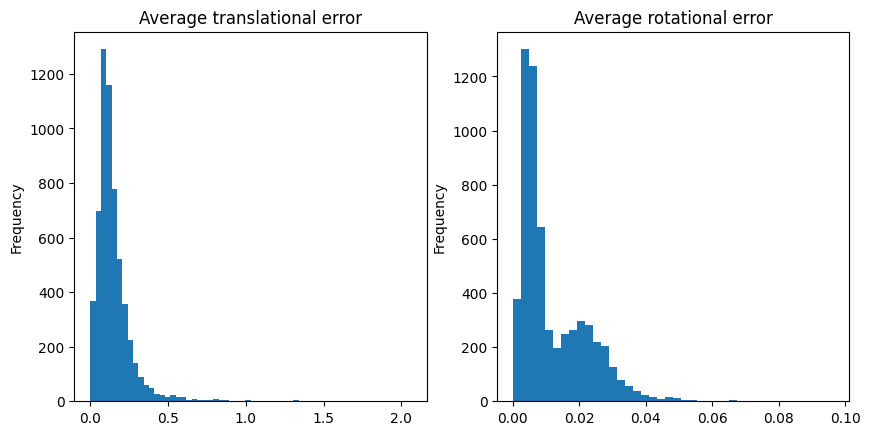

In [6]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
df['translErr'].plot.hist(bins=60, title='Average translational error', ax=ax[0])
df['rotErr'].plot.hist(bins=40, title='Average rotational error', ax=ax[1])
plt.show()

#### Feature Clipping
To perform data rescaling, every value that is above $k = 99th\ percentile$ is clipped to $k$.

In [7]:
rot = df['rotErr'].copy()
rot[rot > rot.quantile(.995)] = rot.quantile(.995)
df['rotErr'] = rot

transl = df['translErr'].copy()
transl[transl > transl.quantile(.995)] = transl.quantile(.995)
df['translErr'] = transl


#### Data rescaling

In [8]:
rescaler_rot = sk.preprocessing.MinMaxScaler()
rescaler_transl = sk.preprocessing.MinMaxScaler()
df['rotErr'] = rescaler_rot.fit_transform(df['rotErr'].values.reshape(-1,1)).squeeze()
df['translErr'] = rescaler_transl.fit_transform(df['translErr'].values.reshape(-1,1)).squeeze()
df['area'] /= df['area'].max()
df.head()

,id,translErr,rotErr,area
0,data/img/32-G5.png,0.651595,1.000000,0.097354
1,data/img/32-G7.png,0.777247,0.984398,0.193957
2,data/img/32-G9.png,0.546994,0.718890,0.101897
3,data/img/32-D8.png,0.614334,0.846781,0.147976
4,data/img/W31-2.png,0.263803,0.349292,0.081962


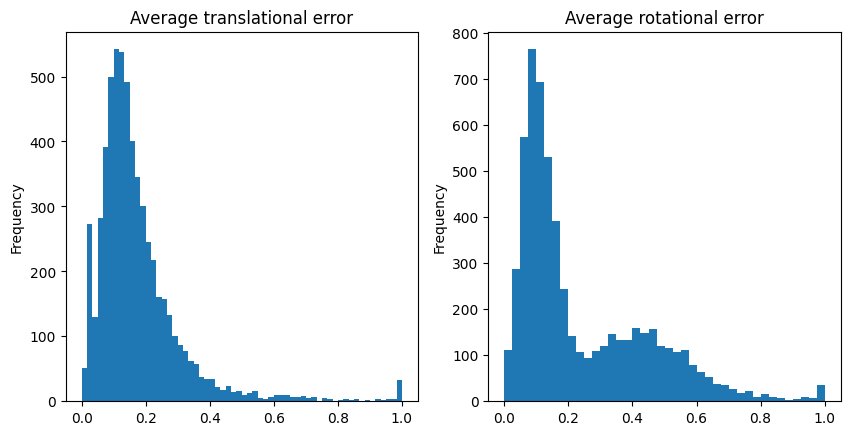

In [9]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
df['translErr'].plot.hist(bins=60, title='Average translational error', ax=ax[0])
df['rotErr'].plot.hist(bins=40, title='Average rotational error', ax=ax[1])
plt.show()

##### Data partitioning and dataset creation

In [10]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [11]:
def load_image(id: tf.types.experimental):
    image = tf.io.read_file(id)
    image = tf.image.decode_png(image, channels=3)
    return image

def data_augmentation(img: np.ndarray):
    rotation = random.randint(0, 3)
    img = tf.image.rot90(img, k=rotation)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_flip_left_right(img)
    return img


def load_dataset(df: pd.DataFrame, augment=False) -> tf.data.Dataset:
    X = tf.data.Dataset.from_tensor_slices(df["id"].values)
    area = tf.data.Dataset.from_tensor_slices(df["area"].values)
    Y = tf.data.Dataset.from_tensor_slices(df[["translErr", "rotErr"]].values)

    X = X.map(load_image, num_parallel_calls=AUTO)
    
    if augment:
        X = X.map(lambda img: data_augmentation(img), num_parallel_calls=AUTO)

    dataset = tf.data.Dataset.zip((X, area), Y)
    dataset = dataset.shuffle(500)
    dataset = dataset.batch(
        batch_size=BATCH_SIZE,
        num_parallel_calls=AUTO,
        deterministic=False,
        drop_remainder=False,
    )
    dataset = dataset.prefetch(AUTO)
    return dataset


train_data = load_dataset(train_df, augment=True)
val_data = load_dataset(val_df)
test_data = load_dataset(test_df)

2024-09-26 14:54:22.537337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 14:54:22.539368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 14:54:22.541463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
train_data.take(1).get_single_element()

((<tf.Tensor: shape=(64, 500, 500, 3), dtype=uint8, numpy=
  array([[[[205, 205, 205],
           [205, 205, 205],
           [205, 205, 205],
           ...,
           [205, 205, 205],
           [205, 205, 205],
           [205, 205, 205]],
  
          [[205, 205, 205],
           [205, 205, 205],
           [205, 205, 205],
           ...,
           [205, 205, 205],
           [205, 205, 205],
           [205, 205, 205]],
  
          [[205, 205, 205],
           [205, 205, 205],
           [205, 205, 205],
           ...,
           [205, 205, 205],
           [205, 205, 205],
           [205, 205, 205]],
  
          ...,
  
          [[205, 205, 205],
           [205, 205, 205],
           [205, 205, 205],
           ...,
           [205, 205, 205],
           [205, 205, 205],
           [205, 205, 205]],
  
          [[205, 205, 205],
           [205, 205, 205],
           [205, 205, 205],
           ...,
           [205, 205, 205],
           [205, 205, 205],
           [205

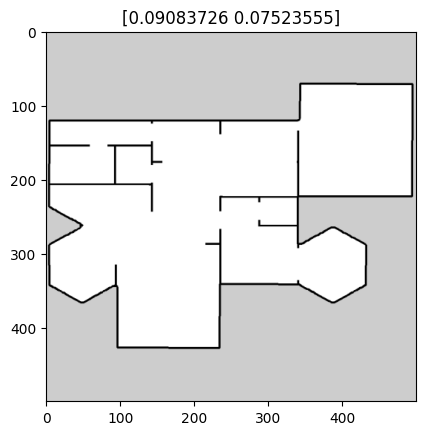

In [13]:
for r in val_data.take(1).as_numpy_iterator():
    r, l = r[0], r[1]
    plt.imshow(r[0][0], cmap='gray')
    plt.title(l[0])
    plt.show()
    break

In [14]:
def plot_history(hst: keras.callbacks.History):
    metrics = ["loss"]
    _, ax = plt.subplots(1, len(metrics), figsize=(15, 5))
    for _, metric in enumerate(metrics):
        ax.plot(hst.history[metric])
        ax.plot(hst.history["val_" + metric])
        ax.set(title="model " + metric, ylabel=metric, xlabel="epoch")
        ax.legend([metric, "val_" + metric], loc="upper left")
    plt.show()

## Define the CNN structure

In [15]:
def _build_efficientNet(input: layers.Layer):
    effNet = keras.applications.EfficientNetV2B3(include_top=False, pooling="avg")
    effNet.trainable = False
    return effNet(input)


def _build_mobileNet(input: layers.Layer):
    mobNet = keras.applications.MobileNetV3Large(include_top=False, pooling="avg")
    mobNet.trainable = False
    return mobNet(input)


def build_model(config: dict) -> keras.Model:  # EfficientNetV2B3
    backbone_builder = {
        "efficientnet": _build_efficientNet,
        "mobilenet": _build_mobileNet,
    }
    backbone = backbone_builder[BACKBONE_MODEL]

    input_layer = layers.Input(shape=IM_SHAPE, name='image_input')
    x = backbone(input_layer)

    # skip connection
    number_input = layers.Input(shape=(1,), name='number_input')
    x = layers.Concatenate()([number_input, x])

    for i in range(config["nLayers"]):
        x = layers.Dense(units=config[f"layer{i}_units"], name=f"dense_{i}")(x)
        if config["batchNorm"]:
            x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)

        if config["dropout"]:
            x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, "relu", name="out_layer")(x)

    model = keras.Model(inputs=[input_layer, number_input], outputs=out, name=f"{BACKBONE_MODEL}_model")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config["lr"]), loss="mse"
    )
    return model

In [16]:
baselineHyperparameters = {
    "lr": 1e-4,
    "nLayers": 3,
    "batchNorm": True,
    "dropout": False,
    "layer0_units": 1024,
    "layer1_units": 512,
    "layer2_units": 128,
}
m = build_model(baselineHyperparameters)

# Sanity check to verify that dataset and model have been built correctly
m.fit(train_data.take(1), batch_size=BATCH_SIZE, epochs=1, validation_data=val_data.take(1))

52606240/52606240 [==============================] - 2s 0us/step


2024-09-26 14:54:36.001487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnet_model/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-26 14:54:36.828030: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-09-26 14:54:37.529471: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 14:54:37.969611: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance g

1/1 [==============================] - 17s 17s/step - loss: 0.2781 - val_loss: 0.0774


### Hyperparameter tuning

In [20]:
def objective(trial: optuna.Trial) -> float:
    best_val_loss = np.inf
    patience = 0
    config = {
        "lr": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        "nLayers": trial.suggest_int("nLayers", 1, 6),
        "batchNorm": trial.suggest_categorical("batchNorm", [True, False]),
        "dropout": trial.suggest_categorical("dropout", [True, False]),
    }
    
    layerDim = [64, 128, 256, 512, 1024, 2048]
    for i in range(config["nLayers"]):
        config[f"layer{i}_units"] = trial.suggest_categorical(
            f"layer{i}_units", layerDim
        )

    model = build_model(config)

    for train_step in range(MAX_EPOCHS):
        history = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data)
        val_loss = history.history["val_loss"][0]
        # Implement earlystopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1

        if patience > 5:
            break

        trial.report(val_loss, train_step)
        if trial.should_prune():
            raise optuna.TrialPruned()
    del model
    return best_val_loss

In [21]:
def kFoldCV(hyperPar: dict, training_set: pd.DataFrame, k: int) -> float:
    df = training_set.reset_index(drop=True)
    kf = KFold(n_splits=k, shuffle=True)
    scores = []
    for trainIdx, valIdx in kf.split(df):
        train_data = load_dataset(df.iloc[trainIdx], augment=True)
        val_data = load_dataset(df.iloc[valIdx])

        model = build_model(hyperPar)
        es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        model.fit(train_data, 
                  batch_size=BATCH_SIZE,
                  validation_data=val_data,
                  epochs=MAX_EPOCHS,
                  callbacks=[es]
                  )
        
        result = model.evaluate(val_data, batch_size=BATCH_SIZE)
        del model
        scores.append(result)
    return np.avg(scores)   # TODO: magari ritorna tutto l'array così calcoli varianza sui fold?

## Optimize EfficientNetV2

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='efficientNet_study'
)

study.enqueue_trial(baselineHyperparameters)    # Test on baseline parameters first and optimize from there
study.optimize(objective, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

[I 2024-09-26 14:56:24,423] A new study created in memory with name: efficientNet_study


A new study created in memory with name: efficientNet_study
A new study created in memory with name: efficientNet_study


2024-09-26 14:56:33.993539: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnet_model/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/65 [============================>.] - ETA: 0s - loss: 0.1256

2024-09-26 14:57:09.201501: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 14:57:09.642017: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


65/65 [==============================] - ETA: 0s - loss: 0.1248

2024-09-26 14:57:19.615627: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 14:57:20.031857: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


18/65 [=======>......................] - ETA: 24s - loss: 0.0729

In [ ]:
plot_slice(study)

In [23]:
study.best_params

In [ ]:
CV_loss_effNet = kFoldCV(study.best_params, train_df, 5)

In [ ]:
model = build_model(study.best_params)
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(test_data, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es])
model.save(f'models/efficientNet_model_{time.strftime("%d%b_%I_%M%p")}.keras')

test_loss_effNet = model.evaluate(test_data)

del model
keras.backend.clear_session()

In [ ]:
print(f'CV loss over training set: {CV_loss_effNet}\nLoss over the test set: {test_loss_effNet}')

## Optimize MobileNetV3_large

In [ ]:
BACKBONE_MODEL = 'mobilenet'

In [ ]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='mobileNet_study'
)

study.enqueue_trial(baselineHyperparameters)    # Test on baseline parameters first and optimize from there
study.optimize(objective, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

In [ ]:
plot_slice(study)

In [ ]:
study.best_params

In [ ]:
CV_loss_mobNet = kFoldCV(study.best_params, train_df, 5)

In [ ]:
model = build_model(study.best_params)
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(test_data, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es])
model.save(f'models/mobileNet_model_{time.strftime("%d%b_%I_%M%p")}.keras')

test_loss_mobNet = model.evaluate(test_data)

del model
keras.backend.clear_session()

In [ ]:
print(f'CV loss over training set: {CV_loss_mobNet}\nLoss over the test set: {test_loss_mobNet}')

## Experimenting with Vision Transformers

In [24]:
FINE_TUNE = False   #set to True to finetune the entire transformer

In [25]:
def build_ViT(config):
    VIT = hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-b16-fe/1")
    VIT.trainable = FINE_TUNE

    input_layer = layers.Input(shape=IM_SHAPE)

    x = layers.Resizing(224,224)(input_layer)
    x = layers.Rescaling(1./127.5, offset=-1)(x)    # Rescaling to [-1, 1] as per ViT spec
    x = VIT(x)
    
    number_input = layers.Input(shape=(1,), name='number_input')
    # skip connection
    x = layers.Concatenate(axis=-1)([x, number_input])
    
    x = layers.Dense(units=config['layer0_units'], activation='relu')(x)

    if config['dropout']:
        x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, "relu", name="out_layer")(x)

    model = keras.Model(inputs=[input_layer, number_input], outputs=out, name=f"{BACKBONE_MODEL}_model")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config["lr"]), loss="mse"
    )
    return model

In [26]:
def objective_ViT(trial: optuna.Trial):
    best_val_loss = np.inf
    patience = 0
    config = {
        "lr": trial.suggest_float("lr", 1e-6, 1e-3, log=True),
        "dropout": trial.suggest_categorical("dropout", [True, False]),
        "layer0_units": trial.suggest_categorical("layer0_units", [64, 128, 256, 512]),
    }

    model = build_ViT(config)

    for train_step in range(MAX_EPOCHS):
        history = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data)
        val_loss = history.history["val_loss"][0]
        # Implement earlystopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1

        if patience > 5:
            break

        trial.report(val_loss, train_step)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    del model
    return best_val_loss

In [27]:
baselineConfig = {
        "lr": 1e-4,
        "dropout": True,
        "layer0_units": 256,
    }
m = build_ViT(baselineConfig)


In [28]:
m.summary()

Model: "efficientnet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 resizing (Resizing)         (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['resizing[0][0]']            
                                                                                                  
 keras_layer (KerasLayer)    (None, 768)                  8579865   ['rescaling_4[0][0]']         
                                                          6                      

In [31]:
m.fit(train_data.take(1), batch_size=BATCH_SIZE, epochs=1, validation_data=val_data.take(1))

1/1 [==============================] - 1s 1s/step - loss: 0.5751 - val_loss: 0.0976


In [ ]:
baselineConfig = {
        "lr": 1e-4,
        "dropout": True,
        "layer0_units": 256,
    }

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='ViT_study'
)

study.enqueue_trial(baselineConfig)    # Test on baseline parameters first and optimize from there
study.optimize(objective_ViT, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

In [24]:
plot_slice(study)

In [ ]:
study.best_params

In [23]:
model = build_ViT(study.best_params)
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
hst = model.fit(test_data, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es])
model_name = f"ViT_model{'_finetuned' if FINE_TUNE else ''}_{time.strftime("%d%b_%I_%M%p")}"
model.save(f'models/{model_name}.keras')

test_loss_ViT = model.evaluate(test_data)

del model
keras.backend.clear_session()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 768)               85798656  
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 86849026 (331.30 MB)
Trainable params: 1050370 

In [ ]:
plot_history(hst)

In [ ]:
print(f"Vision transformer test loss: {test_loss_ViT}")